In [1]:
import pandas as pd
import geopandas as gpd

# Background

This notebook reviews a dataset of HMS smoke data collected from https://satepsanone.nesdis.noaa.gov/pub/FIRE/web/HMS/Smoke_Polygons/Shapefile/ using code/1_collect_HMS_daily_shapes.py. This dataset underwent the following alterations:
* addition of "year" and "date" columns, with values as strings to enable saving as a shapefile.
* addition of columns for days which previously did not have those columns. That is, where 2005-08-05 previously had no Density column, it now has a Density column with NA values. This is the result of concatenating all daily dataframes.

The original rows and crses for each day's shapefile can be viewed using the metadata csv.

## Load data

In [2]:
# load data
f = "../data/hms_smoke_shapes_2005_2021/hms_smoke_shapes_20050805_20211231.shp"
df = gpd.read_file(f)
df

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
0,0.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-121.32000 50.35000, -121.46800 50.4..."
1,1.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-114.67300 47.09400, -114.75200 47.0..."
2,2.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-114.25200 46.02700, -114.30100 46.1..."
3,3.0,1145,1715,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-78.78100 37.51000, -78.74600 37.500..."
4,4.0,1645,1945,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-123.90500 42.73000, -123.95400 42.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...
435637,NaN,2021365 1100,2021365 1600,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-92.22419 19.55040, -92.41493 19.681..."
435638,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-95.21035 16.88020, -95.75144 17.073..."
435639,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-103.78492 20.64871, -103.67599 20.7..."
435640,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-102.01601 20.38415, -102.00044 20.4..."


## Preliminary Stats
How many entries per year?

In [18]:
df.groupby(["year"],dropna=False).size()

year
2005     6296
2006    15273
2007    19881
2008    23285
2009    23344
2010    26774
2011    32092
2012    27964
2013    23107
2014    18565
2015    16247
2016    21280
2017    24739
2018    40948
2019    42945
2020    45329
2021    27573
dtype: int64

Simple chart of number of entries per year:

<AxesSubplot:xlabel='year'>

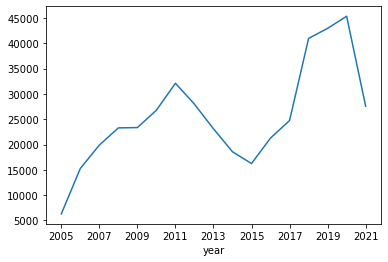

In [17]:
df.groupby(["year"],dropna=False).size().plot()

# Question 1: How complete are the density readings?

Looking through the data, it seemed like years 2005-2007 simply noted presence of smoke instead of a density reading. This section checks presence of non-null values by year.

**Conclusion:**
* 2005-2006 have no Density values
* 2007-2010 have thousands of missing Density values
* 2015 has one day with missing density values
* 2018 has one day with missing density values

In [4]:
# find years 2005-2006
years_0506 = df.loc[(df.date.str.contains("200[56]", regex=True))]
years_0506

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
0,0.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-121.32000 50.35000, -121.46800 50.4..."
1,1.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-114.67300 47.09400, -114.75200 47.0..."
2,2.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-114.25200 46.02700, -114.30100 46.1..."
3,3.0,1145,1715,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-78.78100 37.51000, -78.74600 37.500..."
4,4.0,1645,1945,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-123.90500 42.73000, -123.95400 42.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...
21564,2.0,2145,2245,2006-12-31 00:00:00,2006,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-112.95500 30.91000, -113.08400 30.9..."
21565,3.0,2115,2245,2006-12-31 00:00:00,2006,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-112.77200 31.16800, -112.72100 31.1..."
21566,4.0,2115,2245,2006-12-31 00:00:00,2006,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-112.73700 31.06400, -112.89600 30.9..."
21567,5.0,2115,2245,2006-12-31 00:00:00,2006,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-112.90700 30.88500, -113.01000 30.9..."


In [5]:
# from that dataframe, find years which have a non-NA density value.
years_0506.loc[years_0506.Density.notna()]

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry


From the above, we can conclude that no smoke density value appears for years 2005-6. When does it start to appear during 2007?

In [6]:
df.loc[(df.date.str.contains("2007")) & df.Density.notna()].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
26304,0.0,1245,1615,2007-04-26 00:00:00,2007,5.0,None,None,NaN,NaN,NaN,"POLYGON ((-97.53900 24.31900, -97.04000 24.591..."
26355,51.0,2315,0045,2007-04-26 00:00:00,2007,16.0,None,None,NaN,NaN,NaN,"POLYGON ((-120.87200 42.35200, -120.86400 42.3..."
26354,50.0,2315,0045,2007-04-26 00:00:00,2007,5.0,None,None,NaN,NaN,NaN,"POLYGON ((-120.87200 42.35200, -120.85100 42.3..."
26353,49.0,2315,0045,2007-04-26 00:00:00,2007,5.0,None,None,NaN,NaN,NaN,"POLYGON ((-122.06000 42.07200, -122.02100 42.0..."
26352,48.0,2315,0045,2007-04-26 00:00:00,2007,16.0,None,None,NaN,NaN,NaN,"POLYGON ((-122.04500 42.06400, -122.01600 42.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
41203,1.0,1645,1745,2007-12-10 00:00:00,2007,5.0,None,None,NaN,NaN,NaN,"POLYGON ((-81.15200 32.56300, -81.19200 32.583..."
41202,0.0,1645,1745,2007-12-10 00:00:00,2007,5.0,None,None,NaN,NaN,NaN,"POLYGON ((-82.41300 32.37400, -82.45400 32.394..."
41220,18.0,1700,1800,2007-12-10 00:00:00,2007,5.0,None,None,NaN,NaN,NaN,"POLYGON ((-155.09300 19.42500, -155.10500 19.3..."
41210,8.0,1945,2015,2007-12-10 00:00:00,2007,5.0,None,None,NaN,NaN,NaN,"POLYGON ((-86.43100 31.17100, -86.45000 31.145..."


The first day we have a Density value recorded is April 26, 2007. Do null values appear in Density after that?

In [7]:
# count occurrence of density values by year
df.groupby(["year", "Density"],dropna=False).size()

year  Density
2005  NaN         6296
2006  NaN        15273
2007  5.0          178
      16.0          61
      27.0          19
      NaN        19623
2008  5.0        11561
      16.0        4757
      27.0        1891
      NaN         5076
2009  5.0          101
      16.0          38
      27.0           9
      NaN        23196
2010  5.0        13842
      16.0        4075
      27.0        1411
      NaN         7446
2011  5.0        23193
      16.0        6635
      27.0        2264
2012  5.0        19855
      16.0        6109
      27.0        2000
2013  5.0        16580
      16.0        4960
      27.0        1567
2014  5.0        14445
      16.0        3243
      27.0         877
2015  5.0        12070
      16.0        3127
      27.0        1038
      NaN           12
2016  5.0        17256
      16.0        3109
      27.0         915
2017  5.0        19609
      16.0        3672
      27.0        1458
2018  5.0        33769
      16.0        4577
      27.0        22

Looks like 2007-10 also have null Density values, and then there are 12 entries in 2015 and 306 entries in 2018 with null Density values. What happened there?

In [8]:
df.loc[(df.year =='2015') & df.Density.isna()]

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
216919,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,clampToGround,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
216920,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
216921,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-81.05400 26.80300, -80.99000 26.795..."
216922,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-80.78300 26.42000, -80.66700 26.406..."
216923,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-97.06800 35.66100, -97.01800 35.676..."
216924,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-99.16500 35.75300, -99.08200 35.611..."
216925,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.75400 30.54600, -86.55300 30.652..."
216926,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.85700 30.83300, -86.79400 30.939..."
216927,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-123.84700 43.26200, -123.88300 43.2..."
216928,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-122.78900 40.20000, -122.86600 40.2..."


In [9]:
df.loc[(df.year =='2018') & df.Density.isna()].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
284693,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-76.83591 20.80711, -76.83103 20.799..."
284900,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-85.95254 31.98455, -85.36831 31.574..."
284899,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.02014 32.05215, -85.98634 31.786..."
284898,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.00083 33.33651, -85.92840 33.080..."
284897,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-85.33451 33.22545, -85.22345 32.897..."
...,...,...,...,...,...,...,...,...,...,...,...,...
284792,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.57110 31.71646, -87.56622 31.711..."
284791,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.07062 31.26236, -87.05841 31.184..."
284790,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.31866 30.93765, -86.33575 30.888..."
284797,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.51983 32.17056, -87.50763 32.138..."


3/3/2018 and 1/25/2018 lack Density as well as Start/End values.

# Question 2: What kind of NA values exist for start and end?

**Conclusion:**
* January 25, 2015 and March 3, 2018 anomalous in their lack of Start and End dates.

In [10]:
# search for NA Start values
df.loc[(df.Start.isna())].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
216919,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,clampToGround,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
216930,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.66200 30.54600, -86.58700 30.610..."
216929,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-120.60400 38.97900, -120.59000 38.9..."
216927,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-123.84700 43.26200, -123.88300 43.2..."
216926,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.85700 30.83300, -86.79400 30.939..."
...,...,...,...,...,...,...,...,...,...,...,...,...
284791,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.07062 31.26236, -87.05841 31.184..."
284790,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.31866 30.93765, -86.33575 30.888..."
284789,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.47247 30.98892, -86.47247 30.942..."
284796,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.54425 31.93375, -87.53692 31.894..."


search for NA end values

In [11]:
df.loc[(df.End.isna())].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
216919,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,clampToGround,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
216930,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.66200 30.54600, -86.58700 30.610..."
216929,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-120.60400 38.97900, -120.59000 38.9..."
216927,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-123.84700 43.26200, -123.88300 43.2..."
216926,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.85700 30.83300, -86.79400 30.939..."
...,...,...,...,...,...,...,...,...,...,...,...,...
284791,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.07062 31.26236, -87.05841 31.184..."
284790,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.31866 30.93765, -86.33575 30.888..."
284789,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.47247 30.98892, -86.47247 30.942..."
284796,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.54425 31.93375, -87.53692 31.894..."


In [12]:
df.loc[(df.End.isna())].sort_values("date").date.unique()

array(['2015-01-25 00:00:00', '2018-03-03 00:00:00'], dtype=object)

Do either dates have any non-na "Start", "End", or "Density" values?

In [13]:
df.loc[((df.date.str.contains("2015-01-25"))|(df.date.str.contains("2018-03-03")))].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
216919,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,clampToGround,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
216930,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.66200 30.54600, -86.58700 30.610..."
216929,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-120.60400 38.97900, -120.59000 38.9..."
216927,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-123.84700 43.26200, -123.88300 43.2..."
216926,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.85700 30.83300, -86.79400 30.939..."
...,...,...,...,...,...,...,...,...,...,...,...,...
284791,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.07062 31.26236, -87.05841 31.184..."
284790,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.31866 30.93765, -86.33575 30.888..."
284789,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.47247 30.98892, -86.47247 30.942..."
284796,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.54425 31.93375, -87.53692 31.894..."


A simple visual review of all entries for 2015-01-25 indicate that it doesn't, but let's check properly.

In [14]:
df.loc[((df.date.str.contains("2015-01-25"))|(df.date.str.contains("2018-03-03"))) & ((df.End.notna())|(df.Start.notna())|(df.Density.notna()))].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry


No, Nothing.

# Question 3: What missing values exist for "Satellite"? How might present values be used?

**Conclusion:** Few Satellite values have been recorded. Data review alone does not clarify how the present values might be effectively used.

How many rows contain satellite values?

In [15]:
df.loc[df.Satellite.notna()].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
85280,NaN,2009271 1330,2009271 1430,2009-09-28 00:00:00,2009,5.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-106.79600 43.59900, -103.95100 42.1..."
85354,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-115.62200 47.21000, -115.55300 47.4..."
85353,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-120.89700 46.77300, -120.97600 46.6..."
85352,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-113.71100 46.06000, -113.41000 46.4..."
85351,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-115.25900 47.16300, -114.92400 47.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...
435636,NaN,2021365 1100,2021365 1600,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-80.86339 26.67656, -80.87560 26.731..."
435637,NaN,2021365 1100,2021365 1600,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-92.22419 19.55040, -92.41493 19.681..."
435638,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-95.21035 16.88020, -95.75144 17.073..."
435639,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-103.78492 20.64871, -103.67599 20.7..."


What's the occurrence of different Satellite values from 2005-2016?

In [16]:
# count occurrence of density values by year
df.groupby(["year", "Satellite"],dropna=False).size()

year  Satellite      
2005  NaN                 6296
2006  NaN                15273
2007  NaN                19881
2008  NaN                23285
2009  NOAA Satellites      148
      NaN                23196
2010  NOAA Satellites      360
      NaN                26414
2011  NaN                32092
2012  NOAA Satellites       71
      NaN                27893
2013  NaN                23107
2014  NaN                18565
2015  NOAA Satellites      175
      NaN                16072
2016  GOES-EAST           2247
      GOES-WEST             25
      NaN                19008
2017  AVHRR METOP-B          1
      AVHRR NOAA-15          5
      AVHRR NOAA-18          4
      AVHRR NOAA-19          1
      GOES-EAST          21532
      GOES-WEST           3189
      MODIS AQUA             1
      MODIS TERRA            3
      Suomi NPP              3
2018  AVHRR METOP-A          1
      AVHRR NOAA-19          1
      GOES-EAST          38988
      GOES-WEST           1617
      NOAA 20    

# Additional Reference

Previous studies using HMS smoke data:

## Zhou et al. 2021
* Paper: "[Excess of COVID-19 cases and deaths due to fine particulate matter exposure during the 2020 wildfires in the United States](https://pubmed.ncbi.nlm.nih.gov/34389545/)" 
* Repository: [xiaodan-zhou/covid_wildfire](https://github.com/xiaodan-zhou/covid_wildfire)

HMS datasets in repository are:
* [HMS_county_2020.csv](https://github.com/xiaodan-zhou/covid_wildfire/blob/master/data/HMS_county_2020.csv) 
* [HMS_zipCodes_2020.csv](https://github.com/xiaodan-zhou/covid_wildfire/blob/master/data/HMS_zipCodes_2020.csv).

Both CSVs consist of daily readings where the only value which appears is 5,16, or 27. We can therefore conclude that the value shown is chosen from among plume shapes that intersect with the county, not computed.

In the repo code, only HMS_county_2020.csv is used. The code that produced the CSVs does not appear to be included. Here is where hms_county appears in the repo code:

in Utilities.R:
```R
## merge with hazard data 0=nosmoke, 5=(0,10)light, 16=(11-20)medium, 27=(21,32)heavy
hms = read.csv("data/HMS_county_2020.csv")
hms = tidyr::gather(data=hms, key="date", value="hazardmap", -"County", -"GEOID")
hms$date = mdy("01-01-2020") + (as.numeric(substr(hms$date, 2, 5)) - 1)
hms$hazardmap[is.na(hms$hazardmap)] = 0
hms$GEOID = as.factor(as.character(hms$GEOID))
df = merge(df, hms, by.x=c("date", "FIPS"), by.y=c("date", "GEOID"), all.x=T)
# df = df[df$date <= max(hms$date), ]
rm(hms)
```

in Combine.R:
```R
################################ get hazard data ################################ 
# 0=nosmoke, 5=(0,10)light, 16=(11-20)medium, 27=(21,32)heavy
hms = read.csv("HMS_county_2020.csv")
hms = tidyr::gather(data=hms, key="date", value="hazardmap", -"County", -"GEOID")
hms$date = mdy("01-01-2020") + (as.numeric(substr(hms$date, 2, 5)) - 1)
hms$hazardmap[is.na(hms$hazardmap)] = 0
names(hms)[names(hms) == "GEOID"] = "FIPS"
hms$FIPS = substr(100000 + hms$FIPS, 2, 6)
hms = hms[, c("FIPS", "date", "hazardmap")]
max(hms$date[hms$hazardmap == 27])
...
################################ merge all together ################################ 
...
df = left_join(df, hms, by=c("FIPS", "date"))
df = left_join(df, mobility, by=c("FIPS", "date"))
rm(cases, deaths, pop, pm, climate, hms, mobility)
```

"hazardmap" is the smoke density value. 
```R
################################ wildifre contribution to pm2.5 2020 ################################
### wildfire period scenario one 
df$wildfire = NA
df$wildfire = (df$hazardmap==27)&(!is.na(df$hazardmap))
rows1 = (df$wildfire==T)&(!is.na(df$wildfire))

df$pm_wildfire = 0
df$pm_wildfire[rows1] = pmax(df$pm25[rows1] - df$pm25_history[rows1], 0)
df$pm_ambient = df$pm25 - df$pm_wildfire

# check 
sum(rows1)
rm(rows1)
...
################################ save data ################################ 
write.csv(df, 'moddat_Feb2021.csv', row.names=F)
```